In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
%cd "gdrive/MyDrive/Colab Notebooks/VinBrain_Intern/W1/1. U-Net on SIIM dataset"

/content/gdrive/MyDrive/Colab Notebooks/VinBrain_Intern/W1/1. U-Net on SIIM dataset


In [ ]:
# %cd "Dataset"
# !unzip "archive.zip"

In [3]:
# Import library
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

**Dataset**

In [66]:
# define a class to transform image
class ImageTransform():
  def __init__(self):
      self.data_transform = {
              'train': transforms.Compose([
                  # transforms.CenterCrop(256),
                  transforms.ToTensor()
              ]),
              'val': transforms.Compose([
                  # transforms.CenterCrop(256),       
                  transforms.ToTensor()
              ])
          }
  def __call__(self, img, phase = 'train'):
      return self.data_transform[phase](img)

(256, 256)


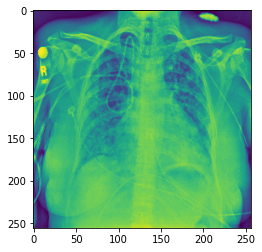

In [6]:
# demo transform an image
img_file_path = "./Dataset/train/1.2.276.0.7230010.3.1.4.8323329.7001.1517875202.297845.png"
img = Image.open(img_file_path)
image_2_npArray = np.asarray(img)
print(np.shape(image_2_npArray))
plt.imshow(img)
plt.show()

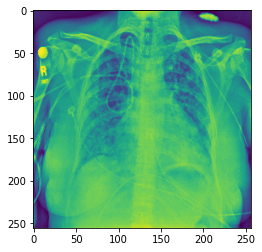

In [7]:
# after transforming an image in dataset
transform = ImageTransform()
img_transformed = transform(img)
img_transformed = np.clip(img_transformed, 0, 1)
img_transformed = img_transformed.view(256, 256)
plt.imshow(img_transformed)

In [8]:
def make_datapath_list(mode = "train"):
    rootpath = "./Dataset/"
    target_path = osp.join(rootpath + mode + "/*.png")
    path_list = []
    for path in glob.glob(target_path):
        path_list.append(path)
    return sorted(path_list)

In [95]:
def make_datapath_list_1(mode = "image"):
    rootpath = "./Dataset/membrane/train/"
    target_path = osp.join(rootpath + mode + "/*.png")
    path_list = []
    for path in glob.glob(target_path):
        path_list.append(path)
    return sorted(path_list)

In [98]:
membrane_img = make_datapath_list_1()
len(membrane_img)
membrane_label = make_datapath_list_1("label")
len(membrane_label)

30

In [9]:
# Test make_datapath_list
image_train_list = len(make_datapath_list())
print(image_train_list)
top10datapath = make_datapath_list()[:10]
top10datapath

12047


['./Dataset/train/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10004.1517875220.929537.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10005.1517875220.958951.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10006.1517875220.954474.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10007.1517875220.954767.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10008.1517875220.957633.png']

In [10]:
image_masks_list = len(make_datapath_list("masks"))
print(image_masks_list)
top10MaskDatapath = make_datapath_list("masks")[:10]
top10MaskDatapath

12047


['./Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10004.1517875220.929537.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10005.1517875220.958951.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10006.1517875220.954474.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10007.1517875220.954767.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10008.1517875220.957633.png']

In [67]:
# create dataset
class ImageDataset(data.Dataset):
    def __init__(self, image_list, mask_list, transform = None, phase = "train"):
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        mask_path = self.mask_list[idx]
        img = Image.open(image_path)
        mask = Image.open(mask_path)

        img_transformed = self.transform(img, self.phase)
        mask_transformed = self.transform(mask, self.phase)
    
        return img_transformed, mask_transformed

In [68]:
# create dataloader
img_train = make_datapath_list()
mask_train = make_datapath_list("masks")

transformed_dataset = ImageDataset(image_list = img_train, mask_list = mask_train, transform = transform)

train_len = int(0.9 * len(transformed_dataset))
validation_len = len(transformed_dataset) - train_len

train_data, val_data = data.dataset.random_split(transformed_dataset,[train_len, validation_len])

train_dataloader = DataLoader(train_data, batch_size = 8, shuffle = True, num_workers = 4)
val_dataloader = DataLoader(val_data, batch_size = 8, shuffle = False, num_workers = 4)

In [112]:
img_train_1 = make_datapath_list_1()
mask_train_1 = make_datapath_list_1("label")

transformed_dataset = ImageDataset(image_list = img_train_1, mask_list = mask_train_1, transform = transform)

train_len = int(1 * len(transformed_dataset))
validation_len = len(transformed_dataset) - train_len

train_data_1, val_data_1 = data.dataset.random_split(transformed_dataset,[train_len, validation_len])

train_dataloader_1 = DataLoader(train_data_1, batch_size = 2, shuffle = True, num_workers = 4)
val_dataloader_1 = DataLoader(val_data_1, batch_size = 2, shuffle = False, num_workers = 4)

In [104]:
print(len(train_data_1))
print(len(val_data_1))

30
0


In [79]:
# Test Dataloader
print(next(iter(train_dataloader)))
input_batch_matrix = torch.FloatTensor(next(iter(train_dataloader))[1])
image_batch_matrix = torch.FloatTensor(next(iter(train_dataloader))[0])
print(input_batch_matrix.size())
# -> each batch consists of (tensor of image, tensor of masks)

[tensor([[[[0.2863, 0.6588, 0.5137,  ..., 0.0039, 0.0039, 0.0039],
          [0.5569, 0.6392, 0.6588,  ..., 0.0627, 0.0471, 0.0196],
          [0.0902, 0.5137, 0.7255,  ..., 0.0471, 0.0314, 0.0275],
          ...,
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0353],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0353],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0353]]],


        [[[0.4235, 0.5098, 0.4588,  ..., 0.0902, 0.1020, 0.1098],
          [0.2627, 0.1686, 0.1490,  ..., 0.0549, 0.0627, 0.0706],
          [0.0980, 0.0863, 0.0667,  ..., 0.0431, 0.0549, 0.0627],
          ...,
          [0.0471, 0.0392, 0.0392,  ..., 0.1412, 0.0588, 0.0353],
          [0.0510, 0.0431, 0.0392,  ..., 0.1176, 0.0510, 0.0392],
          [0.0549, 0.0471, 0.0471,  ..., 0.1059, 0.0471, 0.0275]]],


        [[[0.0392, 0.0392, 0.0510,  ..., 0.0549, 0.0627, 0.0941],
          [0.0392, 0.0510, 0.0510,  ..., 0.0549, 0.0627, 0.0824],
          [0.0510, 0.0510, 0.0510,  .

In [80]:
def show(img, mask):
    grid_img = torchvision.utils.make_grid(img, nrow=4)
    plt.figure()
    plt.imshow(grid_img.permute(1, 2, 0))

    grid_img_1 = torchvision.utils.make_grid(mask, nrow=4)
    plt.figure()
    plt.imshow(grid_img_1.permute(1, 2, 0))

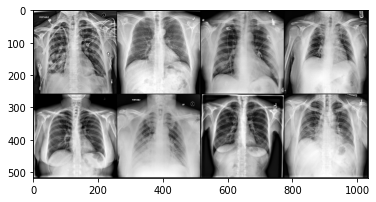

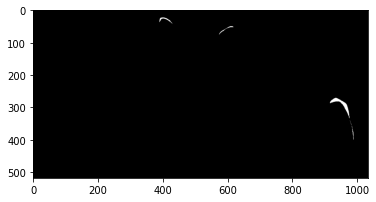

In [81]:
show(image_batch_matrix, input_batch_matrix)

In [82]:
index = 0
# print(train_dataset.__len__())
img, mask = transformed_dataset.__getitem__(index)
print(img.shape)
print(mask)
# img and mask matrix have the same shape 

torch.Size([1, 256, 256])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


**U - Net**

In [18]:
# (conv_layer1 -> BatchNorm -> ReLU) -> (conv_layer2 -> BatchNorm -> ReLU)
class ContractingPathModule(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(ContractingPathModule, self).__init__()
        self.in_chan = in_chan
        self.out_chan = out_chan
        self.conv = nn.Sequential(
            nn.Conv2d(self.in_chan, 
                      self.out_chan, 
                      kernel_size = 3, 
                      stride = 1, 
                      padding = 1, 
                      bias = True),
            nn.ReLU(),
            nn.Conv2d(self.out_chan, 
                      self.out_chan, 
                      kernel_size = 3, 
                      stride = 1, 
                      padding = 1, 
                      bias = True),
            nn.ReLU()
        )
    def forward(self, input):
        return self.conv(input)

In [20]:
  # conv_2d_transpose -> similar to contracting part
  class ExpansivePathModule(nn.Module):
      def __init__(self, in_chan, out_chan):
          super(ExpansivePathModule, self).__init__()
          self.in_chan = in_chan
          self.out_chan = out_chan
          self.conv = nn.Sequential(
              nn.Conv2d(self.out_chan, 
                        self.out_chan, 
                        kernel_size = 3, 
                        stride = 1, 
                        padding = 1, 
                        bias = True),
              nn.ReLU()
          )
          self.upConv = nn.ConvTranspose2d(self.in_chan, 
                                           self.out_chan, 
                                           kernel_size = 2, 
                                           stride = 2)
      def forward(self, input):
          input = self.upConv(input)
          return self.conv(input)


In [21]:
# I now have train_dataloader. Start build a UNet
class UNet(nn.Module):
      def __init__(self, n_channels, n_classes):
          super(UNet, self).__init__()
          self.n_channels = n_channels
          self.n_classes = n_classes

          # Left-side structure of UNet
          self.moduleContract1 = ContractingPathModule(self.n_channels, 64)
          self.moduleContract2 = ContractingPathModule(64, 128)
          self.moduleContract3 = ContractingPathModule(128, 256)
          self.moduleContract4 = ContractingPathModule(256, 512)
          self.moduleContract5 = ContractingPathModule(512, 1024)

          # Right-side structure of UNet
          self.moduleExpansive1 = ExpansivePathModule(1024, 512)
          self.Up_conv5 = ContractingPathModule(1024, 512)

          self.moduleExpansive2 = ExpansivePathModule(512, 256)
          self.Up_conv4 = ContractingPathModule(512, 256)
          
          self.moduleExpansive3 = ExpansivePathModule(256, 128)
          self.Up_conv3 = ContractingPathModule(256, 128)
          
          self.moduleExpansive4 = ExpansivePathModule(128, 64)
          self.Up_conv2 = ContractingPathModule(128, 64)

          # # Final Layer
          self.out_layer = nn.Sequential(
                              nn.Conv2d(64, 2, kernel_size = 3, stride = 1),
                              nn.ReLU(),
                              nn.Conv2d(2, 
                                     self.n_classes,  
                                     kernel_size = 1, 
                                     stride = 1, 
                                     padding = 1
                              ),
                              nn.Sigmoid()
          )

      def forward(self, input):
          # Stage 1
          conv_1 = self.moduleContract1(input)
          pool_1 = nn.MaxPool2d(kernel_size = 2, stride = 2)(conv_1)
          
          conv_2 = self.moduleContract2(pool_1)
          pool_2 =  nn.MaxPool2d(kernel_size = 2, stride = 2)(conv_2)
          
          conv_3 =  self.moduleContract3(pool_2)
          pool_3 =  nn.MaxPool2d(kernel_size = 2, stride = 2)(conv_3)
          
          conv_4 =  self.moduleContract4(pool_3)
          drop_4 = nn.Dropout(0.5)(conv_4)
          pool_4 =  nn.MaxPool2d(kernel_size = 2, stride = 2)(drop_4)
          
          conv_5 = self.moduleContract5(pool_4)
          drop_5 = nn.Dropout(0.5)(conv_5)
    
          # Stage 2
          x_6 = self.moduleExpansive1(drop_5)
          x_6 = torch.cat((drop_4, x_6), dim = 1)
          x_6 = self.Up_conv5(x_6)
        
          x_7 = self.moduleExpansive2(x_6)
          x_7 = torch.cat((conv_3, x_7), dim = 1)
          x_7 = self.Up_conv4(x_7)
          

          x_8 = self.moduleExpansive3(x_7)
          x_8 = torch.cat((conv_2, x_8), dim = 1)
          x_8 = self.Up_conv3(x_8)

          x_9 = self.moduleExpansive4(x_8)
          x_9 = torch.cat((conv_1, x_9), dim = 1)
          x_9 = self.Up_conv2(x_9)
          
          # Final Stage
          output = self.out_layer(x_9)
          return output

In [ ]:
# net = UNet(n_channels = 1, n_classes = 1)
# input = torch.rand(4, 1, 256, 256)
# pred = net(input)
# pred.size()

In [ ]:
# print(net)

**TRAIN MODEL**

In [107]:
# hyper parameter
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels = 1, n_classes = 1)
optimizer = optim.Adam(net.parameters(), lr = 1e-4)

In [108]:
net.to(device = device)

UNet(
  (moduleContract1): ContractingPathModule(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (moduleContract2): ContractingPathModule(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (moduleContract3): ContractingPathModule(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (moduleContract4): ContractingPathModule(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(5

In [24]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
pytorch_total_params 

34166085

In [33]:
SMOOTH = 1e-6

def iou(outputs, labels):
    outputs = outputs.squeeze(1)  
    intersection = (outputs & labels).float().sum((1, 2)) 
    union = (outputs | labels).float().sum((1, 2))         
    iou = (intersection + SMOOTH) / (union + SMOOTH)  
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  
    return thresholded.mean() 

In [30]:
checkpoint = torch.load("./ckpts/checkpoint_4.pt")
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
print(loss)
# net.train()

0.3106381151801838


In [26]:
def dic_loss(pred, target):

    smooth = 1.
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
  
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [113]:
# Train model with dataset

for epoch in range(10):
    print("Epoch {}/{}".format(epoch, num_epochs))
    net.train()
    epoch_loss = 0.0
    epoch_dice_loss = 0.0
    accuracy = 0
    for image, masks in tqdm(train_dataloader_1):
        optimizer.zero_grad()
        image = image.to(device = device, dtype = torch.float32)
        masks = masks.to(device = device, dtype = torch.float32)
        masks_pred = net(image)
        loss = F.binary_cross_entropy(masks_pred, masks)
        dice_loss = dic_loss(masks_pred, masks)
        prediction = (masks_pred.detach() > 0.5).type(torch.int)
        target = (masks > 0.5).type(torch.int)
        print("IoU_score: ", iou(prediction, target))
        accuracy += iou(prediction, target)
        epoch_loss += loss.item()
        epoch_dice_loss += dice_loss.item()
        loss.backward()
        optimizer.step()
            
    epoch_loss = epoch_loss / len(train_dataloader_1)
    epoch_dice_loss = epoch_dice_loss / len(train_dataloader_1)
    print("Train Loss: {:.4f}".format(epoch_loss))
    print("Train Dice Loss: {:.4f}".format(epoch_dice_loss))
    print("Accuracy After Epoch: ", accuracy / len(train_dataloader_1))
    # if (epoch == 4):
    #   torch.save({
    #           'epoch': epoch,
    #           'model_state_dict': net.state_dict(),
    #           'optimizer_state_dict': optimizer.state_dict(),
    #           'loss': epoch_loss,
    #         }, "./ckpts/checkpoint_{:d}.pt".format(epoch))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/2


  7%|▋         | 1/15 [00:00<00:03,  4.08it/s]

IoU_score:  tensor(0.4920, device='cuda:0')
IoU_score:  tensor(0.4518, device='cuda:0')
IoU_score:  tensor(0.5039, device='cuda:0')


 33%|███▎      | 5/15 [00:00<00:01,  6.13it/s]

IoU_score:  tensor(0.4297, device='cuda:0')
IoU_score:  tensor(0.4264, device='cuda:0')
IoU_score:  tensor(0.4363, device='cuda:0')


 60%|██████    | 9/15 [00:00<00:00,  8.18it/s]

IoU_score:  tensor(0.5146, device='cuda:0')
IoU_score:  tensor(0.5627, device='cuda:0')
IoU_score:  tensor(0.5357, device='cuda:0')


 73%|███████▎  | 11/15 [00:01<00:00,  9.05it/s]

IoU_score:  tensor(0.5381, device='cuda:0')
IoU_score:  tensor(0.5512, device='cuda:0')
IoU_score:  tensor(0.4580, device='cuda:0')


100%|██████████| 15/15 [00:01<00:00, 10.36it/s]

IoU_score:  tensor(0.5166, device='cuda:0')
IoU_score:  tensor(0.4922, device='cuda:0')
IoU_score:  tensor(0.5703, device='cuda:0')


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3679
Train Dice Loss: 0.0866
Accuracy After Epoch:  tensor(0.4986, device='cuda:0')
Epoch 1/2


 20%|██        | 3/15 [00:00<00:02,  5.07it/s]

IoU_score:  tensor(0.4551, device='cuda:0')
IoU_score:  tensor(0.4857, device='cuda:0')
IoU_score:  tensor(0.4711, device='cuda:0')


 33%|███▎      | 5/15 [00:00<00:01,  6.12it/s]

IoU_score:  tensor(0.4559, device='cuda:0')
IoU_score:  tensor(0.4824, device='cuda:0')
IoU_score:  tensor(0.4873, device='cuda:0')


 47%|████▋     | 7/15 [00:00<00:01,  7.18it/s]

IoU_score:  tensor(0.5172, device='cuda:0')
IoU_score:  tensor(0.4576, device='cuda:0')
IoU_score:  tensor(0.4691, device='cuda:0')


 73%|███████▎  | 11/15 [00:01<00:00,  9.05it/s]

IoU_score:  tensor(0.5875, device='cuda:0')
IoU_score:  tensor(0.5869, device='cuda:0')
IoU_score:  tensor(0.5475, device='cuda:0')


100%|██████████| 15/15 [00:01<00:00, 10.36it/s]

IoU_score:  tensor(0.5338, device='cuda:0')
IoU_score:  tensor(0.5547, device='cuda:0')
IoU_score:  tensor(0.4947, device='cuda:0')


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3519
Train Dice Loss: 0.0807
Accuracy After Epoch:  tensor(0.5058, device='cuda:0')
Epoch 2/2


 20%|██        | 3/15 [00:00<00:02,  5.16it/s]

IoU_score:  tensor(0.4559, device='cuda:0')
IoU_score:  tensor(0.4479, device='cuda:0')
IoU_score:  tensor(0.4930, device='cuda:0')


 33%|███▎      | 5/15 [00:00<00:01,  6.24it/s]

IoU_score:  tensor(0.5375, device='cuda:0')
IoU_score:  tensor(0.4596, device='cuda:0')
IoU_score:  tensor(0.5107, device='cuda:0')


 60%|██████    | 9/15 [00:00<00:00,  8.27it/s]

IoU_score:  tensor(0.4924, device='cuda:0')
IoU_score:  tensor(0.5029, device='cuda:0')
IoU_score:  tensor(0.5691, device='cuda:0')


 73%|███████▎  | 11/15 [00:01<00:00,  9.12it/s]

IoU_score:  tensor(0.4707, device='cuda:0')
IoU_score:  tensor(0.4645, device='cuda:0')
IoU_score:  tensor(0.4289, device='cuda:0')


100%|██████████| 15/15 [00:01<00:00, 10.41it/s]

IoU_score:  tensor(0.5082, device='cuda:0')
IoU_score:  tensor(0.4227, device='cuda:0')
IoU_score:  tensor(0.4725, device='cuda:0')


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3488
Train Dice Loss: 0.0806
Accuracy After Epoch:  tensor(0.4824, device='cuda:0')
Epoch 3/2


 20%|██        | 3/15 [00:00<00:02,  5.40it/s]

IoU_score:  tensor(0.5289, device='cuda:0')
IoU_score:  tensor(0.5139, device='cuda:0')
IoU_score:  tensor(0.2967, device='cuda:0')


 33%|███▎      | 5/15 [00:00<00:01,  6.48it/s]

IoU_score:  tensor(0.2914, device='cuda:0')
IoU_score:  tensor(0.2992, device='cuda:0')
IoU_score:  tensor(0.4285, device='cuda:0')


 60%|██████    | 9/15 [00:00<00:00,  8.47it/s]

IoU_score:  tensor(0.4121, device='cuda:0')
IoU_score:  tensor(0.4660, device='cuda:0')
IoU_score:  tensor(0.4674, device='cuda:0')


 73%|███████▎  | 11/15 [00:01<00:00,  9.29it/s]

IoU_score:  tensor(0.3945, device='cuda:0')
IoU_score:  tensor(0.4592, device='cuda:0')
IoU_score:  tensor(0.4715, device='cuda:0')


 87%|████████▋ | 13/15 [00:01<00:00,  9.98it/s]

IoU_score:  tensor(0.5322, device='cuda:0')
IoU_score:  tensor(0.5201, device='cuda:0')
IoU_score:  tensor(0.5512, device='cuda:0')


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3597
Train Dice Loss: 0.0857
Accuracy After Epoch:  tensor(0.4422, device='cuda:0')
Epoch 4/2


 20%|██        | 3/15 [00:00<00:02,  5.49it/s]

IoU_score:  tensor(0.5492, device='cuda:0')
IoU_score:  tensor(0.5334, device='cuda:0')
IoU_score:  tensor(0.6156, device='cuda:0')


 33%|███▎      | 5/15 [00:00<00:01,  6.57it/s]

IoU_score:  tensor(0.4797, device='cuda:0')
IoU_score:  tensor(0.4822, device='cuda:0')
IoU_score:  tensor(0.4359, device='cuda:0')


 60%|██████    | 9/15 [00:00<00:00,  8.56it/s]

IoU_score:  tensor(0.4666, device='cuda:0')
IoU_score:  tensor(0.5021, device='cuda:0')
IoU_score:  tensor(0.4965, device='cuda:0')


 73%|███████▎  | 11/15 [00:01<00:00,  9.35it/s]

IoU_score:  tensor(0.4502, device='cuda:0')
IoU_score:  tensor(0.5096, device='cuda:0')
IoU_score:  tensor(0.5707, device='cuda:0')


100%|██████████| 15/15 [00:01<00:00, 10.56it/s]

IoU_score:  tensor(0.5438, device='cuda:0')
IoU_score:  tensor(0.5396, device='cuda:0')
IoU_score:  tensor(0.4783, device='cuda:0')


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3316
Train Dice Loss: 0.0752
Accuracy After Epoch:  tensor(0.5102, device='cuda:0')
Epoch 5/2


 20%|██        | 3/15 [00:00<00:02,  5.06it/s]

IoU_score:  tensor(0.5234, device='cuda:0')
IoU_score:  tensor(0.5697, device='cuda:0')
IoU_score:  tensor(0.4070, device='cuda:0')


 33%|███▎      | 5/15 [00:00<00:01,  6.13it/s]

IoU_score:  tensor(0.4846, device='cuda:0')
IoU_score:  tensor(0.5443, device='cuda:0')
IoU_score:  tensor(0.5170, device='cuda:0')


 60%|██████    | 9/15 [00:00<00:00,  8.17it/s]

IoU_score:  tensor(0.5182, device='cuda:0')
IoU_score:  tensor(0.5262, device='cuda:0')
IoU_score:  tensor(0.5230, device='cuda:0')


 73%|███████▎  | 11/15 [00:01<00:00,  9.05it/s]

IoU_score:  tensor(0.4656, device='cuda:0')
IoU_score:  tensor(0.4631, device='cuda:0')
IoU_score:  tensor(0.5729, device='cuda:0')


100%|██████████| 15/15 [00:01<00:00, 10.35it/s]

IoU_score:  tensor(0.4830, device='cuda:0')
IoU_score:  tensor(0.5148, device='cuda:0')
IoU_score:  tensor(0.5076, device='cuda:0')


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3280
Train Dice Loss: 0.0745
Accuracy After Epoch:  tensor(0.5080, device='cuda:0')
Epoch 6/2


 20%|██        | 3/15 [00:00<00:02,  5.09it/s]

IoU_score:  tensor(0.5461, device='cuda:0')
IoU_score:  tensor(0.5279, device='cuda:0')
IoU_score:  tensor(0.5152, device='cuda:0')


 33%|███▎      | 5/15 [00:00<00:01,  6.18it/s]

IoU_score:  tensor(0.5285, device='cuda:0')
IoU_score:  tensor(0.4879, device='cuda:0')
IoU_score:  tensor(0.5723, device='cuda:0')


 60%|██████    | 9/15 [00:00<00:00,  8.24it/s]

IoU_score:  tensor(0.5086, device='cuda:0')
IoU_score:  tensor(0.5355, device='cuda:0')
IoU_score:  tensor(0.4545, device='cuda:0')


 73%|███████▎  | 11/15 [00:01<00:00,  9.10it/s]

IoU_score:  tensor(0.4768, device='cuda:0')
IoU_score:  tensor(0.4600, device='cuda:0')
IoU_score:  tensor(0.4680, device='cuda:0')


100%|██████████| 15/15 [00:01<00:00, 10.39it/s]

IoU_score:  tensor(0.4951, device='cuda:0')
IoU_score:  tensor(0.5664, device='cuda:0')
IoU_score:  tensor(0.5148, device='cuda:0')


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3226
Train Dice Loss: 0.0721
Accuracy After Epoch:  tensor(0.5105, device='cuda:0')
Epoch 7/2


 20%|██        | 3/15 [00:00<00:02,  5.43it/s]

IoU_score:  tensor(0.5434, device='cuda:0')
IoU_score:  tensor(0.5166, device='cuda:0')
IoU_score:  tensor(0.4650, device='cuda:0')


 33%|███▎      | 5/15 [00:00<00:01,  6.50it/s]

IoU_score:  tensor(0.4490, device='cuda:0')
IoU_score:  tensor(0.4627, device='cuda:0')
IoU_score:  tensor(0.5787, device='cuda:0')


 60%|██████    | 9/15 [00:00<00:00,  8.48it/s]

IoU_score:  tensor(0.5197, device='cuda:0')
IoU_score:  tensor(0.5232, device='cuda:0')
IoU_score:  tensor(0.4934, device='cuda:0')


 73%|███████▎  | 11/15 [00:01<00:00,  9.25it/s]

IoU_score:  tensor(0.5895, device='cuda:0')
IoU_score:  tensor(0.5535, device='cuda:0')
IoU_score:  tensor(0.4951, device='cuda:0')


100%|██████████| 15/15 [00:01<00:00, 10.49it/s]

IoU_score:  tensor(0.6084, device='cuda:0')
IoU_score:  tensor(0.4605, device='cuda:0')
IoU_score:  tensor(0.4625, device='cuda:0')


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3176
Train Dice Loss: 0.0714
Accuracy After Epoch:  tensor(0.5148, device='cuda:0')
Epoch 8/2


 20%|██        | 3/15 [00:00<00:02,  5.04it/s]

IoU_score:  tensor(0.5648, device='cuda:0')
IoU_score:  tensor(0.4986, device='cuda:0')
IoU_score:  tensor(0.5256, device='cuda:0')


 33%|███▎      | 5/15 [00:00<00:01,  6.11it/s]

IoU_score:  tensor(0.4859, device='cuda:0')
IoU_score:  tensor(0.5170, device='cuda:0')
IoU_score:  tensor(0.4912, device='cuda:0')


 60%|██████    | 9/15 [00:00<00:00,  8.15it/s]

IoU_score:  tensor(0.4088, device='cuda:0')
IoU_score:  tensor(0.4285, device='cuda:0')
IoU_score:  tensor(0.5613, device='cuda:0')


 73%|███████▎  | 11/15 [00:01<00:00,  9.03it/s]

IoU_score:  tensor(0.5783, device='cuda:0')
IoU_score:  tensor(0.5463, device='cuda:0')
IoU_score:  tensor(0.5244, device='cuda:0')


100%|██████████| 15/15 [00:01<00:00, 10.36it/s]

IoU_score:  tensor(0.4990, device='cuda:0')
IoU_score:  tensor(0.4383, device='cuda:0')
IoU_score:  tensor(0.5168, device='cuda:0')


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3214
Train Dice Loss: 0.0717
Accuracy After Epoch:  tensor(0.5057, device='cuda:0')
Epoch 9/2


 20%|██        | 3/15 [00:00<00:02,  5.24it/s]

IoU_score:  tensor(0.3941, device='cuda:0')
IoU_score:  tensor(0.4465, device='cuda:0')
IoU_score:  tensor(0.4520, device='cuda:0')


 33%|███▎      | 5/15 [00:00<00:01,  6.31it/s]

IoU_score:  tensor(0.4469, device='cuda:0')
IoU_score:  tensor(0.4770, device='cuda:0')
IoU_score:  tensor(0.5594, device='cuda:0')


 60%|██████    | 9/15 [00:00<00:00,  8.32it/s]

IoU_score:  tensor(0.4852, device='cuda:0')
IoU_score:  tensor(0.5469, device='cuda:0')
IoU_score:  tensor(0.5240, device='cuda:0')


 73%|███████▎  | 11/15 [00:01<00:00,  9.17it/s]

IoU_score:  tensor(0.5756, device='cuda:0')
IoU_score:  tensor(0.4943, device='cuda:0')
IoU_score:  tensor(0.5619, device='cuda:0')


100%|██████████| 15/15 [00:01<00:00, 10.45it/s]

IoU_score:  tensor(0.5910, device='cuda:0')
IoU_score:  tensor(0.4570, device='cuda:0')
IoU_score:  tensor(0.5141, device='cuda:0')


100%|██████████| 15/15 [00:01<00:00, 10.26it/s]

Train Loss: 0.3157
Train Dice Loss: 0.0711
Accuracy After Epoch:  tensor(0.5017, device='cuda:0')


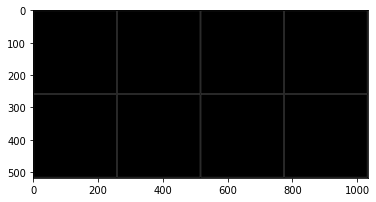

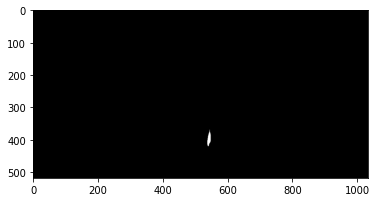

In [88]:
# print(train_dataset.__len__())
img, mask = next(iter(train_dataloader))
img = img.to(device = device, dtype = torch.float32)
answer = net(img)
answer = answer.type(torch.float)
 
# print((answer))
# print(mask)    

grid_img = torchvision.utils.make_grid(answer, nrow=4)
plt.figure()
plt.imshow(grid_img.detach().cpu().permute(1, 2, 0))

grid_img = torchvision.utils.make_grid(mask, nrow=4)
plt.figure()
plt.imshow(grid_img.permute(1, 2, 0))

# plt.figure()
# plt.imshow(answer.view(256, 256).detach().cpu().numpy(), cmap="gray")
# plt.figure()
# plt.imshow(mask.view(256, 256), cmap='gray')

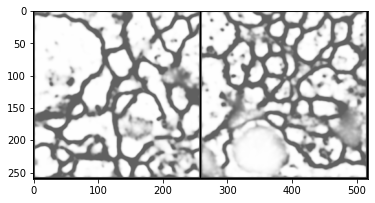

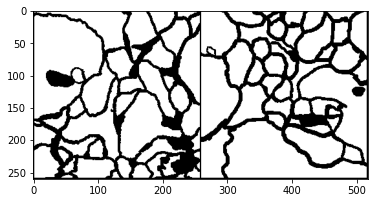

In [116]:
# print(train_dataset_1.__len__())
img, mask = next(iter(train_dataloader_1))
img = img.to(device = device, dtype = torch.float32)
answer = net(img)
answer = answer.type(torch.float)
 
# print((answer))
# print(mask)    

grid_img = torchvision.utils.make_grid(answer, nrow=4)
plt.figure()
plt.imshow(grid_img.detach().cpu().permute(1, 2, 0))

grid_img = torchvision.utils.make_grid(mask, nrow=4)
plt.figure()
plt.imshow(grid_img.permute(1, 2, 0))


In [35]:
net.eval()
with torch.no_grad():
    loss = 0.0
    dice_loss = 0.0
    accuracy = 0
    for image, masks in tqdm(val_dataloader):
        image = image.to(device = device, dtype = torch.float32)
        masks = masks.to(device = device, dtype = torch.float32)
        masks_pred = net(image)
        loss = F.binary_cross_entropy(masks_pred, masks)
        dice_loss = dic_loss(masks_pred, masks) 
        prediction = (masks_pred.detach() > 0.5).type(torch.int)
        target = (masks > 0.5).type(torch.int)
        print("IoU_score: ", iou(prediction, target))
        accuracy += iou(prediction, target)
        loss += loss.item() * 8
        dice_loss += dice_loss.item() * 8
            
    loss = loss / len(val_dataloader.dataset)
    dice_loss = dice_loss / len(val_dataloader.dataset)
    print("Val Loss: {:.4f}".format(loss))
    print("Val Dice Loss: {:.4f}".format(dice_loss))
    print("Iou Score: ", accuracy / len(val_dataloader))

  1%|▏         | 2/151 [00:00<00:36,  4.13it/s]

IoU_score:  tensor(0.8989, device='cuda:0')
IoU_score:  tensor(1., device='cuda:0')


  3%|▎         | 4/151 [00:00<00:25,  5.82it/s]

IoU_score:  tensor(0.9697, device='cuda:0')
IoU_score:  tensor(0.9180, device='cuda:0')


  4%|▍         | 6/151 [00:00<00:20,  7.17it/s]

IoU_score:  tensor(0.9033, device='cuda:0')
IoU_score:  tensor(0.9907, device='cuda:0')


  5%|▌         | 8/151 [00:01<00:17,  8.32it/s]

IoU_score:  tensor(0.9326, device='cuda:0')
IoU_score:  tensor(0.9321, device='cuda:0')


  6%|▌         | 9/151 [00:01<00:16,  8.64it/s]

IoU_score:  tensor(0.9917, device='cuda:0')


  7%|▋         | 10/151 [00:03<02:09,  1.08it/s]

IoU_score:  tensor(0.9365, device='cuda:0')


  8%|▊         | 12/151 [00:04<01:22,  1.68it/s]

IoU_score:  tensor(0.8335, device='cuda:0')
IoU_score:  tensor(0.9233, device='cuda:0')


  9%|▊         | 13/151 [00:04<01:01,  2.24it/s]

IoU_score:  tensor(0.8862, device='cuda:0')


  9%|▉         | 14/151 [00:07<02:36,  1.15s/it]

IoU_score:  tensor(0.9492, device='cuda:0')


 10%|▉         | 15/151 [00:07<02:09,  1.05it/s]

IoU_score:  tensor(0.9941, device='cuda:0')


 11%|█▏        | 17/151 [00:08<01:22,  1.63it/s]

IoU_score:  tensor(0.9414, device='cuda:0')
IoU_score:  tensor(0.9785, device='cuda:0')


 12%|█▏        | 18/151 [00:11<02:32,  1.15s/it]

IoU_score:  tensor(1., device='cuda:0')


 13%|█▎        | 19/151 [00:11<02:12,  1.00s/it]

IoU_score:  tensor(0.9355, device='cuda:0')


 14%|█▍        | 21/151 [00:12<01:25,  1.52it/s]

IoU_score:  tensor(0.9067, device='cuda:0')
IoU_score:  tensor(0.9663, device='cuda:0')


 15%|█▍        | 22/151 [00:14<02:26,  1.14s/it]

IoU_score:  tensor(0.9263, device='cuda:0')


 15%|█▌        | 23/151 [00:15<01:59,  1.07it/s]

IoU_score:  tensor(1., device='cuda:0')


 17%|█▋        | 25/151 [00:15<01:09,  1.82it/s]

IoU_score:  tensor(1., device='cuda:0')
IoU_score:  tensor(1., device='cuda:0')


 17%|█▋        | 26/151 [00:18<02:29,  1.19s/it]

IoU_score:  tensor(1., device='cuda:0')
IoU_score:  

 18%|█▊        | 27/151 [00:18<01:47,  1.15it/s]

tensor(0.9541, device='cuda:0')


 19%|█▉        | 29/151 [00:19<01:10,  1.72it/s]

IoU_score:  tensor(0.8799, device='cuda:0')
IoU_score:  tensor(0.9102, device='cuda:0')


 20%|█▉        | 30/151 [00:21<02:33,  1.27s/it]

IoU_score:  tensor(0.9629, device='cuda:0')


 21%|██        | 31/151 [00:22<02:06,  1.05s/it]

IoU_score:  tensor(0.9346, device='cuda:0')


 22%|██▏       | 33/151 [00:23<01:29,  1.32it/s]

IoU_score:  tensor(0.9512, device='cuda:0')
IoU_score:  tensor(0.9600, device='cuda:0')


 23%|██▎       | 34/151 [00:25<02:06,  1.09s/it]

IoU_score:  tensor(0.8989, device='cuda:0')
IoU_score:  

 23%|██▎       | 35/151 [00:25<01:34,  1.22it/s]

tensor(0.9126, device='cuda:0')


 25%|██▍       | 37/151 [00:26<01:16,  1.48it/s]

IoU_score:  tensor(0.9731, device='cuda:0')
IoU_score:  tensor(0.9507, device='cuda:0')


 26%|██▌       | 39/151 [00:29<01:37,  1.15it/s]

IoU_score:  tensor(0.9766, device='cuda:0')
IoU_score:  tensor(0.9771, device='cuda:0')


 27%|██▋       | 41/151 [00:30<01:17,  1.41it/s]

IoU_score:  tensor(0.9927, device='cuda:0')
IoU_score:  tensor(0.9521, device='cuda:0')


 28%|██▊       | 43/151 [00:32<01:30,  1.19it/s]

IoU_score:  tensor(0.9390, device='cuda:0')
IoU_score:  tensor(0.9800, device='cuda:0')


 30%|██▉       | 45/151 [00:34<01:07,  1.57it/s]

IoU_score:  tensor(0.9575, device='cuda:0')
IoU_score:  tensor(0.9556, device='cuda:0')


 31%|███       | 47/151 [00:36<01:23,  1.25it/s]

IoU_score:  tensor(0.9863, device='cuda:0')
IoU_score:  tensor(0.9854, device='cuda:0')


 32%|███▏      | 49/151 [00:37<00:57,  1.76it/s]

IoU_score:  tensor(0.9463, device='cuda:0')
IoU_score:  tensor(0.9409, device='cuda:0')


 34%|███▍      | 51/151 [00:40<01:39,  1.00it/s]

IoU_score:  tensor(0.8384, device='cuda:0')
IoU_score:  tensor(0.9233, device='cuda:0')


 35%|███▌      | 53/151 [00:40<00:53,  1.84it/s]

IoU_score:  tensor(1., device='cuda:0')
IoU_score:  tensor(0.9600, device='cuda:0')


 36%|███▋      | 55/151 [00:43<01:28,  1.09it/s]

IoU_score:  tensor(0.9595, device='cuda:0')
IoU_score:  tensor(0.9736, device='cuda:0')


 38%|███▊      | 57/151 [00:44<00:48,  1.94it/s]

IoU_score:  tensor(0.9751, device='cuda:0')
IoU_score:  tensor(0.9238, device='cuda:0')


 39%|███▉      | 59/151 [00:47<01:29,  1.02it/s]

IoU_score:  tensor(0.9731, device='cuda:0')
IoU_score:  tensor(0.9419, device='cuda:0')


 40%|████      | 61/151 [00:47<00:47,  1.88it/s]

IoU_score:  tensor(0.9336, device='cuda:0')
IoU_score:  tensor(0.9580, device='cuda:0')


 42%|████▏     | 63/151 [00:50<01:13,  1.19it/s]

IoU_score:  tensor(0.9482, device='cuda:0')
IoU_score:  tensor(1., device='cuda:0')


 43%|████▎     | 65/151 [00:51<00:49,  1.75it/s]

IoU_score:  tensor(0.9521, device='cuda:0')
IoU_score:  tensor(0.9443, device='cuda:0')


 44%|████▍     | 67/151 [00:53<01:07,  1.24it/s]

IoU_score:  tensor(1., device='cuda:0')
IoU_score:  tensor(0.9546, device='cuda:0')


 46%|████▌     | 69/151 [00:54<00:45,  1.81it/s]

IoU_score:  tensor(0.8789, device='cuda:0')
IoU_score:  tensor(0.9463, device='cuda:0')


 47%|████▋     | 71/151 [00:56<01:07,  1.18it/s]

IoU_score:  tensor(0.9434, device='cuda:0')
IoU_score:  tensor(0.9243, device='cuda:0')


 48%|████▊     | 73/151 [00:58<00:54,  1.43it/s]

IoU_score:  tensor(0.9126, device='cuda:0')
IoU_score:  tensor(0.9648, device='cuda:0')


 50%|████▉     | 75/151 [01:00<01:04,  1.18it/s]

IoU_score:  tensor(0.9199, device='cuda:0')
IoU_score:  tensor(0.9209, device='cuda:0')


 51%|█████     | 77/151 [01:01<00:48,  1.53it/s]

IoU_score:  tensor(0.9717, device='cuda:0')
IoU_score:  tensor(0.8906, device='cuda:0')


 52%|█████▏    | 79/151 [01:03<00:55,  1.30it/s]

IoU_score:  tensor(1., device='cuda:0')
IoU_score:  tensor(0.9805, device='cuda:0')


 54%|█████▎    | 81/151 [01:05<00:50,  1.39it/s]

IoU_score:  tensor(0.9155, device='cuda:0')
IoU_score:  tensor(0.9390, device='cuda:0')


 55%|█████▍    | 83/151 [01:07<00:56,  1.20it/s]

IoU_score:  tensor(0.9204, device='cuda:0')
IoU_score:  tensor(0.9375, device='cuda:0')


 56%|█████▋    | 85/151 [01:08<00:40,  1.64it/s]

IoU_score:  tensor(0.9688, device='cuda:0')
IoU_score:  tensor(0.9702, device='cuda:0')


 58%|█████▊    | 87/151 [01:10<00:49,  1.30it/s]

IoU_score:  tensor(0.9595, device='cuda:0')
IoU_score:  tensor(1., device='cuda:0')


 59%|█████▉    | 89/151 [01:11<00:37,  1.66it/s]

IoU_score:  tensor(0.8999, device='cuda:0')
IoU_score:  tensor(0.9463, device='cuda:0')


 60%|██████    | 91/151 [01:14<00:47,  1.26it/s]

IoU_score:  tensor(0.9644, device='cuda:0')
IoU_score:  tensor(1., device='cuda:0')


 62%|██████▏   | 93/151 [01:15<00:43,  1.34it/s]

IoU_score:  tensor(0.8428, device='cuda:0')
IoU_score:  tensor(0.9609, device='cuda:0')


 63%|██████▎   | 95/151 [01:17<00:42,  1.32it/s]

IoU_score:  tensor(0.9580, device='cuda:0')
IoU_score:  tensor(0.8877, device='cuda:0')


 64%|██████▍   | 97/151 [01:19<00:37,  1.43it/s]

IoU_score:  tensor(0.9126, device='cuda:0')
IoU_score:  tensor(0.9482, device='cuda:0')


 66%|██████▌   | 99/151 [01:21<00:41,  1.27it/s]

IoU_score:  tensor(0.9673, device='cuda:0')
IoU_score:  tensor(0.9297, device='cuda:0')


 67%|██████▋   | 101/151 [01:22<00:31,  1.59it/s]

IoU_score:  tensor(0.9771, device='cuda:0')
IoU_score:  tensor(0.9736, device='cuda:0')


 68%|██████▊   | 103/151 [01:24<00:40,  1.18it/s]

IoU_score:  tensor(0.9614, device='cuda:0')
IoU_score:  tensor(0.9722, device='cuda:0')


 70%|██████▉   | 105/151 [01:25<00:28,  1.60it/s]

IoU_score:  tensor(0.9429, device='cuda:0')
IoU_score:  tensor(0.8984, device='cuda:0')


 71%|███████   | 107/151 [01:28<00:36,  1.19it/s]

IoU_score:  tensor(0.9541, device='cuda:0')
IoU_score:  tensor(1., device='cuda:0')


 72%|███████▏  | 109/151 [01:28<00:22,  1.84it/s]

IoU_score:  tensor(0.9692, device='cuda:0')
IoU_score:  tensor(0.9077, device='cuda:0')


 74%|███████▎  | 111/151 [01:31<00:31,  1.28it/s]

IoU_score:  tensor(0.9771, device='cuda:0')
IoU_score:  tensor(0.9199, device='cuda:0')


 74%|███████▍  | 112/151 [01:31<00:27,  1.41it/s]

IoU_score:  tensor(0.9395, device='cuda:0')
IoU_score:  

 75%|███████▍  | 113/151 [01:31<00:20,  1.85it/s]

tensor(0.9688, device='cuda:0')


 76%|███████▌  | 115/151 [01:34<00:30,  1.19it/s]

IoU_score:  tensor(0.9478, device='cuda:0')
IoU_score:  tensor(0.9688, device='cuda:0')


 77%|███████▋  | 116/151 [01:34<00:24,  1.44it/s]

IoU_score:  tensor(0.9644, device='cuda:0')


 77%|███████▋  | 117/151 [01:35<00:18,  1.82it/s]

IoU_score:  tensor(0.9810, device='cuda:0')


 79%|███████▉  | 119/151 [01:37<00:26,  1.20it/s]

IoU_score:  tensor(0.9751, device='cuda:0')
IoU_score:  tensor(1., device='cuda:0')


 79%|███████▉  | 120/151 [01:38<00:25,  1.23it/s]

IoU_score:  tensor(0.9419, device='cuda:0')


 80%|████████  | 121/151 [01:38<00:20,  1.50it/s]

IoU_score:  tensor(0.9663, device='cuda:0')


 81%|████████▏ | 123/151 [01:40<00:20,  1.39it/s]

IoU_score:  tensor(0.9546, device='cuda:0')
IoU_score:  tensor(0.9829, device='cuda:0')


 83%|████████▎ | 125/151 [01:42<00:21,  1.22it/s]

IoU_score:  tensor(0.9727, device='cuda:0')
IoU_score:  tensor(0.9004, device='cuda:0')


 84%|████████▍ | 127/151 [01:43<00:14,  1.68it/s]

IoU_score:  tensor(0.9619, device='cuda:0')
IoU_score:  tensor(0.9761, device='cuda:0')


 85%|████████▌ | 129/151 [01:46<00:18,  1.22it/s]

IoU_score:  tensor(0.8936, device='cuda:0')
IoU_score:  tensor(0.9805, device='cuda:0')


 87%|████████▋ | 131/151 [01:47<00:12,  1.64it/s]

IoU_score:  tensor(0.9458, device='cuda:0')
IoU_score:  tensor(0.8740, device='cuda:0')


 88%|████████▊ | 133/151 [01:49<00:15,  1.20it/s]

IoU_score:  tensor(0.9805, device='cuda:0')
IoU_score:  tensor(0.9316, device='cuda:0')


 89%|████████▉ | 135/151 [01:50<00:09,  1.68it/s]

IoU_score:  tensor(0.9214, device='cuda:0')
IoU_score:  tensor(0.8999, device='cuda:0')


 90%|█████████ | 136/151 [01:53<00:18,  1.26s/it]

IoU_score:  tensor(0.9668, device='cuda:0')
IoU_score:  

 91%|█████████▏| 138/151 [01:53<00:08,  1.49it/s]

tensor(0.9741, device='cuda:0')
IoU_score:  tensor(0.9507, device='cuda:0')
IoU_score:  

 92%|█████████▏| 139/151 [01:53<00:06,  2.00it/s]

tensor(0.9736, device='cuda:0')


 93%|█████████▎| 141/151 [01:56<00:09,  1.11it/s]

IoU_score:  tensor(0.9839, device='cuda:0')
IoU_score:  tensor(0.8911, device='cuda:0')


 95%|█████████▍| 143/151 [01:57<00:03,  2.02it/s]

IoU_score:  tensor(1., device='cuda:0')
IoU_score:  tensor(0.9897, device='cuda:0')


 96%|█████████▌| 145/151 [02:00<00:05,  1.07it/s]

IoU_score:  tensor(0.9556, device='cuda:0')
IoU_score:  tensor(0.9873, device='cuda:0')


 97%|█████████▋| 147/151 [02:00<00:02,  1.96it/s]

IoU_score:  tensor(0.9546, device='cuda:0')
IoU_score:  tensor(1., device='cuda:0')


 99%|█████████▊| 149/151 [02:03<00:01,  1.09it/s]

IoU_score:  tensor(1., device='cuda:0')
IoU_score:  tensor(0.9512, device='cuda:0')


 99%|█████████▉| 150/151 [02:03<00:00,  1.48it/s]

IoU_score:  tensor(0.9810, device='cuda:0')
IoU_score:  tensor(0.9820, device='cuda:0')


100%|██████████| 151/151 [02:03<00:00,  1.22it/s]


NameError: ignored